In [2]:
%pip install boto3 sagemaker
%pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/ee/2c/03d466d00818c8e0ffcf778946ca4a5e05694a11b85bc51f1bc5c18ca54e/xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.1-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import io
import os
import joblib

import pandas as pd
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoost
from sagemaker.model import Model

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, \
                            ConfusionMatrixDisplay, precision_score, recall_score, \
                            f1_score, roc_curve, roc_auc_score

from xgboost import XGBClassifier

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
s3_bucket = 'sagemaker-studio-073855787749-u265vam8zvs'
data_key = 'input/On-time-delivery-data.csv'
data_location = f's3://{s3_bucket}/{data_key}'

sagemaker_session = sagemaker.Session()

s3_client = boto3.client('s3')
# Define your role
role = get_execution_role()

# Read the dataset from S3 into a Pandas DataFrame
df = pd.read_csv(data_location)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
#EDA

df.head()

,zipcode,total_items,precipitation_rate,water_runoff,snow_depth,temperature,temperature_at_1500m,min_temperature,max_temperature,pressure,wind_gust_speed,total_cloud_cover,dew_point_temperature,relative_humidity,wind_speed,classification_ontime
0,2719,518.0,0.0,1.80,0.0,2.24,-5.41,-3.32,4.36,102949.50,9.09,80.5,-2.44,71.58,4.892280,Delayed
1,92545,969.0,0.0,0.40,0.0,12.17,6.87,4.76,19.41,94921.35,3.16,0.0,-6.60,28.81,2.376716,Delayed
2,27357,216.0,0.0,2.05,0.0,5.30,0.92,0.41,11.21,98834.30,8.92,92.5,0.63,73.53,3.213254,On time
3,81211,402.0,0.0,0.13,0.0,-0.28,10.12,-3.24,5.16,70768.17,6.00,16.0,-5.72,67.84,3.751669,Delayed
4,67220,246.0,0.0,0.04,0.0,11.71,7.29,5.90,17.24,96777.72,15.99,5.0,5.49,66.28,9.623910,On time


In [6]:
df.dtypes

zipcode                    int64
total_items              float64
precipitation_rate       float64
water_runoff             float64
snow_depth               float64
temperature              float64
temperature_at_1500m     float64
min_temperature          float64
max_temperature          float64
pressure                 float64
wind_gust_speed          float64
total_cloud_cover        float64
dew_point_temperature    float64
relative_humidity        float64
wind_speed               float64
classification_ontime     object
dtype: object

In [7]:
df.describe()

,zipcode,total_items,precipitation_rate,water_runoff,snow_depth,temperature,temperature_at_1500m,min_temperature,max_temperature,pressure,wind_gust_speed,total_cloud_cover,dew_point_temperature,relative_humidity,wind_speed
count,45000.000000,45000.000000,45000.0,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,48087.534356,745.937689,0.0,1.746789,0.017405,5.366044,1.101344,1.463699,9.685610,98712.437251,7.194286,57.223122,-0.594257,70.183491,3.791066
std,29470.984048,722.175529,0.0,2.287030,0.050950,8.994406,8.581042,9.030691,9.355469,4542.604461,3.590518,34.306560,9.136050,18.770509,1.819227
min,1001.000000,102.000000,0.0,0.000000,0.000000,-28.500000,-28.830000,-34.050000,-24.620000,65960.900000,0.520000,0.000000,-32.350000,8.410000,0.364730
25%,22315.000000,216.000000,0.0,0.160000,0.000000,-0.490000,-5.100000,-3.920000,3.150000,98249.255000,4.350000,26.700000,-6.370000,58.520000,2.444013
50%,45601.000000,491.000000,0.0,0.970000,0.000000,4.840000,1.905000,0.810000,9.540000,99784.020000,6.910000,61.500000,-1.250000,73.110000,3.472554
75%,75570.000000,1028.000000,0.0,2.470000,0.000000,12.010000,7.830000,7.470000,16.650000,101200.000000,9.670000,91.000000,5.370000,85.660000,4.803201
max,99403.000000,4604.000000,0.0,61.510000,1.140000,27.540000,23.100000,25.100000,35.130000,103945.500000,30.550000,100.000000,21.760000,100.010000,21.021189


<Figure size 300x300 with 0 Axes>

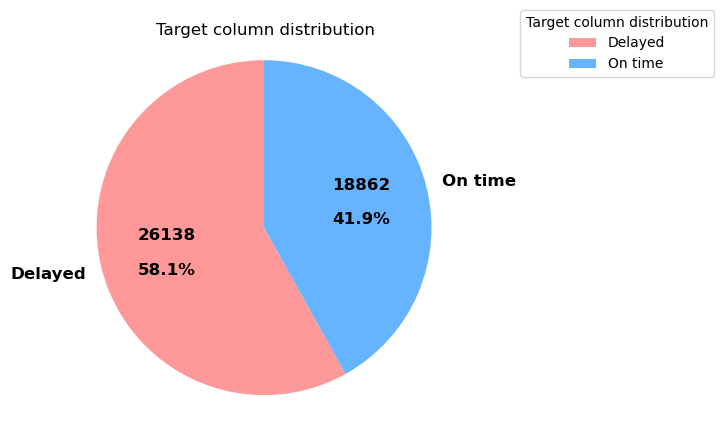

In [5]:

category_counts = df['classification_ontime'].value_counts()
plt.figure(figsize=(3, 3))
fig, ax = plt.subplots()
colors = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.axis('equal')

# Add category labels
ax.legend(wedges, category_counts.index, title='Target column distribution', loc="center left", bbox_to_anchor=(1, 0.5, 0.5, 1))

# Add counts inside the pie chart
for text, autotext, count in zip(texts, autotexts, category_counts):
    text.set(size=12, weight='bold')
    autotext.set(size=12, weight='bold', color='black')
    autotext.set_text(f'{count}\n\n{autotext.get_text()}')
plt.title('Target column distribution')

plt.show()

In [9]:
#check for null values

df.isnull().sum()

zipcode                  0
total_items              0
precipitation_rate       0
water_runoff             0
snow_depth               0
temperature              0
temperature_at_1500m     0
min_temperature          0
max_temperature          0
pressure                 0
wind_gust_speed          0
total_cloud_cover        0
dew_point_temperature    0
relative_humidity        0
wind_speed               0
classification_ontime    0
dtype: int64

In [10]:
df['zipcode'].nunique()

14442

In [34]:
#data preprocessing

def group_zipcodes(zipcode):
    # Use the first 3 digits to group zip codes
    return str(zipcode)[:1]

def feature_selection(df):
    clf = RandomForestClassifier()
    
    X = df.drop('classification_ontime', axis=1)
    Y = df['classification_ontime']
    clf.fit(X, Y)

    feature_importances = clf.feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    threshold = 0.01

    selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']
    
    return selected_features.tolist() + ['classification_ontime']

def preprocess(df, typedf='train', scaler = StandardScaler(), selection=False, columns_to_remove = []):
    if typedf=='train':
        df_new = df.loc[:, df.apply(pd.Series.nunique) != 1]
        r_cols = [col for col in df.columns if col not in df_new.columns]
        if r_cols:
            [columns_to_remove.append(col) for col in r_cols]
    else:
        df_new = df.loc[:, [col for col in df.columns if col not in columns_to_remove]]
    # grouping zipcode to reduce cardinality

    # Apply the grouping function to the 'zipcode' column
    df_new['zipcode_grouped'] = df_new['zipcode'].apply(group_zipcodes)
    df_new = df_new.loc[:, df_new.columns != 'zipcode']
    
    if selection:
        if typedf=='train':
            important_features = feature_selection(df_new)
            r_cols = [col for col in df_new.columns if col not in important_features]
            if r_cols:
                [columns_to_remove.append(col) for col in r_cols]
            df_new = df_new[important_features]
        else:
            df_new = df_new.loc[:, [col for col in df_new.columns if col not in columns_to_remove]]
        
    
    # Initialize the StandardScaler
    categorical_columns = ['classification_ontime','zipcode_grouped']
    numeric_columns = [col for col in df_new.columns if col not in categorical_columns]
    
    # Fit the StandardScaler on the training data and transform the training data
    df_std = df_new.copy()
    if typedf=='train':
        df_std[numeric_columns] = scaler.fit_transform(df_new[numeric_columns])
    else:
        df_std[numeric_columns] = scaler.transform(df_new[numeric_columns])
    
    # onehotencoding
    df_std = pd.get_dummies(df_std, columns=['zipcode_grouped'])
    df_std_X = df_std.drop('classification_ontime', axis=1)
    df_std['classification_ontime'] = df_std['classification_ontime'].apply(lambda x: 1 if x=='On time' else 0)
    df_std_Y = df_std['classification_ontime']
    df_std_X = df_std_X.reset_index(drop=True)
    df_std_Y = df_std_Y.reset_index(drop=True)
    if typedf=='train':
        return df_std_X, df_std_Y, scaler, columns_to_remove
    return df_std_X, df_std_Y
    
    

In [35]:
def split_dataset(df):    
    # Split the data into train, validation, and test sets
    train_data, test_data = train_test_split(df, test_size=0.1, random_state=42, stratify = df['classification_ontime'])
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify = train_data['classification_ontime'])

    # Upload train, validation, and test datasets to S3
    for dataset, dataset_name in [(train_data, 'train.csv'), (val_data, 'validation.csv'), (test_data, 'test.csv')]:
        # Convert the DataFrame to CSV format
        csv_buffer = io.StringIO()
        dataset.to_csv(csv_buffer, index=False)

        # Upload the CSV to S3
        s3_key = os.path.join('input', dataset_name)
        s3_client.put_object(Bucket=s3_bucket, Key=s3_key, Body=csv_buffer.getvalue())

    # Get the counts of the split datasets
    train_count = len(train_data)
    val_count = len(val_data)
    test_count = len(test_data)

    # Print the counts
    print(f"Train dataset count: {train_count} samples")
    print(f"Validation dataset count: {val_count} samples")
    print(f"Test dataset count: {test_count} samples")
    
    return train_data, val_data, test_data

In [36]:
train_data, val_data, test_data = split_dataset(df)

Train dataset count: 32400 samples
Validation dataset count: 8100 samples
Test dataset count: 4500 samples


In [37]:
scaler = StandardScaler()
selection = True

train_X, train_Y, scaler_obj, columns_to_remove = preprocess(train_data, typedf='train',  scaler = scaler, selection=selection)
val_X, val_Y = preprocess(val_data, typedf='val', scaler=scaler_obj, selection=selection, columns_to_remove=columns_to_remove)
test_X, test_Y = preprocess(test_data, typedf='test', scaler=scaler_obj, selection=selection, columns_to_remove=columns_to_remove)

In [111]:
train_X.head()

,total_items,water_runoff,snow_depth,temperature,temperature_at_1500m,min_temperature,max_temperature,pressure,wind_gust_speed,total_cloud_cover,...,wind_speed,zipcode_grouped_1,zipcode_grouped_2,zipcode_grouped_3,zipcode_grouped_4,zipcode_grouped_5,zipcode_grouped_6,zipcode_grouped_7,zipcode_grouped_8,zipcode_grouped_9
34703,-0.442875,0.090215,-0.343633,1.579069,1.269679,1.412846,1.647280,0.332201,1.345079,0.873001,...,0.599615,0,1,0,0,0,0,0,0,0
39676,-0.814618,-0.145814,-0.343633,0.124871,-0.158117,-0.363980,0.247221,-0.052640,0.502442,-0.103946,...,-0.365966,1,0,0,0,0,0,0,0,0
20673,-0.195508,-0.539196,5.953264,-1.672403,-1.871705,-1.760531,-1.648982,0.194554,-1.068812,1.173376,...,-0.914938,0,0,0,0,1,0,0,0,0
14896,-0.133320,-0.377472,-0.343633,0.094990,0.176468,-0.108259,0.222733,0.040313,-1.185614,-0.430566,...,-0.915466,0,0,0,0,0,1,0,0,0
38458,1.449003,-0.609130,0.837035,-0.849021,-0.546143,-1.048478,-0.758906,-1.964954,-0.935325,0.619287,...,-0.561277,0,0,0,0,0,0,0,0,1


In [93]:
val_X.head()

,total_items,water_runoff,snow_depth,temperature,temperature_at_1500m,min_temperature,max_temperature,pressure,wind_gust_speed,total_cloud_cover,...,wind_speed,zipcode_grouped_1,zipcode_grouped_2,zipcode_grouped_3,zipcode_grouped_4,zipcode_grouped_5,zipcode_grouped_6,zipcode_grouped_7,zipcode_grouped_8,zipcode_grouped_9
192,-0.856076,0.383065,-0.343633,1.768314,1.506677,2.044435,1.617469,0.452688,1.306145,1.217120,...,0.612826,0,0,1,0,0,0,0,0,0
5129,0.275735,0.007167,-0.343633,-0.452824,-0.051236,-0.154553,0.617731,-0.296411,0.416231,1.246282,...,0.003550,0,0,0,0,0,0,1,0,0
42543,0.883789,1.799239,-0.343633,1.063349,1.486927,1.027059,1.160720,0.523933,1.987485,0.639700,...,0.534114,0,1,0,0,0,0,0,0,0
5076,-0.836729,1.126119,-0.343633,-0.073228,-0.282425,0.102271,-0.173330,-0.022881,2.140439,0.940075,...,2.134450,1,0,0,0,0,0,0,0,0
40452,-0.570014,0.780818,-0.343633,-0.375356,-0.938816,-0.539238,-0.344744,0.459581,-0.774029,-1.217956,...,-0.781868,0,0,0,0,0,0,0,0,1


In [10]:
xgb = XGBClassifier()

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
# }

skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

grid_search = GridSearchCV(xgb, param_grid, cv=skf.split(train_X, train_Y), scoring='accuracy')

grid_search.fit(train_X, train_Y)

# Get the best parameters
best_params = grid_search.best_params_

# Create the XGBoost classifier with the best parameters
best_xgb = XGBClassifier(**best_params)

# Fit the best model on the training data
best_xgb.fit(train_X, train_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Validation Accuracy: 0.83
Precision: 0.78
Recall: 0.82
F1 Score: 0.80
AUC: 0.83


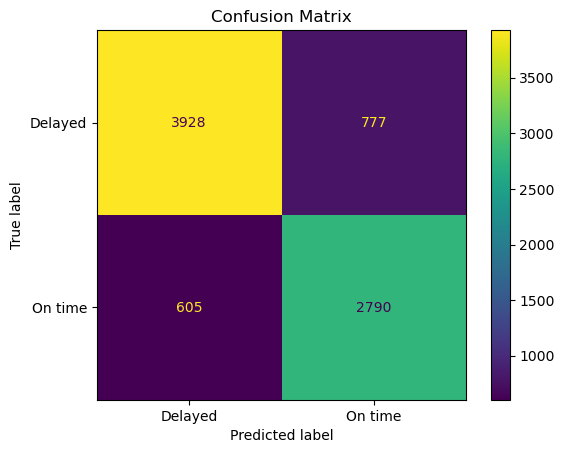

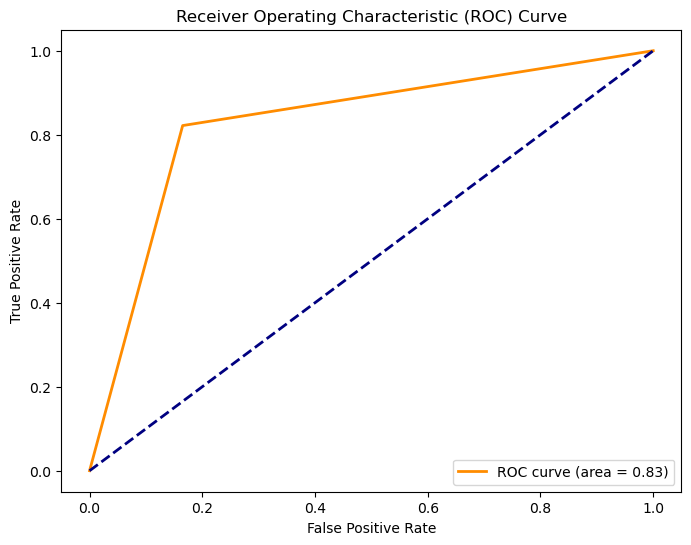

In [20]:


# Predict on the validation data
val_Y_pred = best_xgb.predict(val_X)

# Calculate accuracy
accuracy = accuracy_score(val_Y, val_Y_pred)
precision = precision_score(val_Y, val_Y_pred)
recall = recall_score(val_Y, val_Y_pred)
f1 = f1_score(val_Y, val_Y_pred)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(val_Y, val_Y_pred)
roc_auc = roc_auc_score(val_Y, val_Y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("AUC: {:.2f}".format(roc_auc))


# Create and display a modern confusion matrix
cm = confusion_matrix(val_Y, val_Y_pred)
#disp = plot_confusion_matrix(best_xgb, val_X, val_Y, display_labels=, cmap=plt.cm.Blues, values_format='d')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Delayed', 'On time'])
disp.plot()
disp.ax_.set_title('Confusion Matrix')
plt.show()


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [125]:
# with open("./best_xgb_model", "wb") as f:
#     joblib.dump(best_xgb, f)  

best_xgb.save_model("best_xgb_model.model")

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:31:25] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [17]:
# Create a tar.gz archive and add the model file to it

import tarfile
import joblib
import gzip

with tarfile.open('best_xgb.tar.gz', 'w:gz') as tar:
    tar.add('best_xgb_model.model', arcname='best_xgb_model.model')

In [18]:
model_name = 'best_xgb.tar.gz'
model_location = os.path.join('model', model_name)
s3_client.upload_file(Filename=model_name, Bucket=s3_bucket, Key=model_location)

In [23]:
# deploy
model_path = "s3://" + s3_bucket + '/'+ model_location #s3://sagemaker-studio-073855787749-u265vam8zvs/model/best_xgb.tar.gz
container = sagemaker.image_uris.retrieve(region=sagemaker_session.boto_region_name, 
                                framework="xgboost", 
                               version='1.7-1')
# Initialize an XGBoost estimator

#s3://sagemaker-studio-073855787749-u265vam8zvs/input/exp01ontimeornot/sagemaker-automl-candidates/model/WeightedEnsemble-L2-FULL-t4/model.tar.gz
xgb_model = Model(
    model_data=model_path,
    image_uri=container,
    role=role
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [24]:
from datetime import datetime

endpoint_name = f"DEMO-xgboost-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

EndpointName = DEMO-xgboost-2023-11-01-1611


In [25]:
#monitoring

from sagemaker.model_monitor import DataCaptureConfig
s3_capture_upload_path = os.path.join('s3://', s3_bucket, 'capture')


# Configuration object passed in when deploying Models to SM endpoints
data_capture_config = DataCaptureConfig(
    enable_capture = True, 
    destination_s3_uri = s3_capture_upload_path, 
    capture_options = ["REQUEST", "RESPONSE"],
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [26]:
xgb_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
-------!

In [48]:
# deploy

from sagemaker.predictor import Predictor
from sagemaker.deserializers import CSVDeserializer #JSONDeserializer
from sagemaker.serializers import CSVSerializer

predictor = Predictor(endpoint_name=endpoint_name,
                      serializer = CSVSerializer(),
                      deserializer = CSVDeserializer())



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [51]:
#predict from the deployed model

predictor.predict(test_X.iloc[1,:])[0][0]

'0.45272737741470337'

In [64]:
#predict and pro
from time import sleep

train_dataset_name = "train_with_predictions.csv"

limit = 200  # Need at least 200 samples to compute standard deviations
i = 0
with open(f"{train_dataset_name}", "w") as validation_file:
    validation_file.write("probability,prediction,label\n")  # CSV header
    for index, row in train_X.iterrows():
        label = train_Y.iloc[index]
        probability = float(predictor.predict(row)[0][0])
        prediction = "1" if probability > 0.5 else "0"
        validation_file.write(f"{probability},{prediction},{label}\n")
        i += 1
        if i > limit:
            break
        print(".", end="", flush=True)
        sleep(0.2)


print("Done!")

........................................................................................................................................................................................................Done!


In [65]:
s3_client.upload_file(Filename=train_dataset_name, Bucket=s3_bucket, Key=train_dataset_name)

In [68]:
#monitoring

from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size_in_gb=16,
    max_runtime_in_seconds=1800,
    sagemaker_session=sagemaker_session
)

In [69]:
# create a job to get the metrics of the model on test data

baseline_job_name = "MyBaseLineJob"
baseline_dataset_uri = os.path.join('s3://', s3_bucket, 'train_with_predictions.csv') #s3://sagemaker-studio-073855787749-u265vam8zvs/test_with_predictions.csv
baseline_results_uri = os.path.join('s3://', s3_bucket, 'output')
job = model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri, # The S3 location of the validation dataset.
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri = baseline_results_uri, # The S3 location to store the results.
    problem_type='BinaryClassification',
    inference_attribute= "prediction", # The column in the dataset that contains predictions.
    probability_attribute= "probability", # The column in the dataset that contains probabilities.
    ground_truth_attribute= "label" # The column in the dataset that contains ground truth labels.
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name MyBaseLineJob


...............................................................................................!

In [70]:
baseline_job = model_quality_monitor.latest_baselining_job
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.880952,LessThanThreshold
precision,0.891566,LessThanThreshold
accuracy,0.905473,LessThanThreshold
true_positive_rate,0.880952,LessThanThreshold
true_negative_rate,0.923077,LessThanThreshold
false_positive_rate,0.076923,GreaterThanThreshold
false_negative_rate,0.119048,GreaterThanThreshold
auc,0.969678,LessThanThreshold
f0_5,0.889423,LessThanThreshold
f1,0.886228,LessThanThreshold


In [71]:
# Create a low-level SageMaker service client.
sagemaker_client = boto3.client('sagemaker', region_name=sagemaker_session.boto_region_name)

# Delete endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '604f7f98-7e42-46fc-aa2b-beb2b213ebef',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '604f7f98-7e42-46fc-aa2b-beb2b213ebef',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 01 Nov 2023 17:28:57 GMT'},
  'RetryAttempts': 0}}